# ETL
*Extract-transform-load*

This notebook does the data engineering steps required for the Met-ML training and evaluation:

- load fluxnet csvs
- fit transformers on the full dataset
- saves the preprocessed data and transformers for use in the next steps of the project

TODO: 
1. Fix the null/default negative values in the dataset 
2. Revert the copying of hr datasets 
3. Set up evaluation to do cross validation 

In [7]:
# has to be ran on the GCP notebook  

# from gcsfs import GCSFileSystem

# fs = GCSFileSystem(cache_timeout=0)

# missing_sites = [
#     'AU-Tum', 'BR-Sa1', 'CA-SF1', 'CA-TP1', 'DK-NuF', 'DK-ZaF', 'DK-ZaH', 'FI-Lom', 'NO-Adv',
#     'NO-Blv', 'RU-Sam', 'RU-SkP', 'RU-Tks', 'RU-Vrk', 'SE-St1', 'US-Cop', 'US-Ha1', 'US-Me1',
#     'US-MMS', 'US-Ne1', 'US-Ne2', 'US-Ne3', 'US-PFa', 'US-UMB', 'ZA-Kru'
# ]

# for site in missing_sites:
#     wrong = f'gs://carbonplan-data/raw/fluxnet/{site.lower()}_fullset_hr.parquet'
#     correct = f'gs://carbonplan-data/raw/fluxnet/{site.lower()}_fullset_hh.parquet'
#     if fs.exists(wrong):
#         print(site, wrong)
#         fs.cp(wrong, correct, recursive=True)

In [1]:
!mamba install -y -c conda-forge python-snappy openpyxl intake-parquet


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['python-snappy', 'openpyxl', 'intake-parquet']

pkgs/main/linux-64       [>                   ] (--

In [2]:
# %load_ext lab_black

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
# import os
# import intake
import pandas as pd
import numpy as np
# import xarray as xr

# from tqdm import tqdm
# from joblib import dump

# from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
from dask.distributed import Client

# import fsspec


from met_ml.data import cat
from met_ml.train.fluxnet_etl import load_fluxnet, get_meta, make_lookback
# from met_ml.train.models import fit_transformers, transform_df


FOLDER = 's3://pangeo-scratch/cchiao/'

In [4]:
client = Client(n_workers=2)
client

Client Scheduler: tcp://127.0.0.1:45385 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 32.14 GB


In [5]:
# TODO: put this dataset in cat
# also, there may be a new version of this...?

all_site_meta = pd.read_excel("../met_ml/data/FLX_AA-Flx_BIF_LATEST.xlsx").set_index(
    ["SITE_ID", "VARIABLE"]
)["DATAVALUE"]

all_site_meta.head()

SITE_ID  VARIABLE            
AR-SLu   MAP                                      400
         COUNTRY                            Argentina
         DOI                     10.18140/FLX/1440191
         DOI_DATAPRODUCT                  FLUXNET2015
         DOI_CONTRIBUTOR_NAME       Patricio Magliano
Name: DATAVALUE, dtype: object

In [17]:
df = load_fluxnet(cat, all_site_meta)

getting meta data
getting all jobs
computing
prep output
failed to read DK-NuF, look into this...
failed to read DK-ZaF, look into this...
failed to read DK-ZaH, look into this...
failed to read FI-Lom, look into this...
failed to read NO-Adv, look into this...
failed to read NO-Blv, look into this...
failed to read RU-Sam, look into this...
failed to read RU-SkP, look into this...
failed to read RU-Tks, look into this...
failed to read RU-Vrk, look into this...
failed to read SE-St1, look into this...
failed to read US-Me4, look into this...
failed to read ZA-Kru, look into this...
concat


In [18]:
df.head()

precip   t_min   t_max     SW_IN_F     LW_IN_F  \
       TIMESTAMP_START                                                   
AR-SLu 2009-01-01        3.072  18.632  23.105   79.239667  380.892000   
       2009-01-02        0.694  17.421  26.319  254.912292  369.231500   
       2009-01-03        0.000  16.709  30.400  342.819187  346.828625   
       2009-01-04        0.000  20.551  33.735  410.918083  338.023500   
       2009-01-05        0.986  21.835  32.551  306.377375  367.396125   

                             PA_F  RH  doy      lat      lon   elev  
       TIMESTAMP_START                                               
AR-SLu 2009-01-01       95.294625 NaN    1 -33.4648 -66.4598  508.0  
       2009-01-02       95.597354 NaN    2 -33.4648 -66.4598  508.0  
       2009-01-03       95.650583 NaN    3 -33.4648 -66.4598  508.0  
       2009-01-04       95.272437 NaN    4 -33.4648 -66.4598  508.0  
       2009-01-05       94.955813 NaN    5 -33.4648 -66.4598  508.0

In [19]:
df.count()
# missing RH 

precip     519753
t_min      519753
t_max      519753
SW_IN_F    519753
LW_IN_F    519753
PA_F       519753
RH         438443
doy        519753
lat        519753
lon        519753
elev       519753
dtype: int64

In [20]:
df.describe()

,precip,t_min,t_max,SW_IN_F,LW_IN_F,PA_F,RH,doy,lat,lon,elev
count,519753.000000,519753.000000,519753.000000,519753.000000,519753.000000,519753.000000,438443.000000,519753.000000,519753.000000,519753.000000,519753.000000
mean,2.280667,5.628738,14.563891,162.899147,310.151736,95.151641,71.728991,183.126048,38.452990,-21.621544,560.308085
std,6.527114,11.203335,12.369629,100.896675,57.802712,7.118535,18.915338,105.439202,22.676287,77.635797,684.124254
min,0.000000,-52.883000,-50.003000,0.000000,96.774875,59.154937,1.654000,1.000000,-37.425900,-157.408900,-9.000000
25%,0.000000,-0.660000,6.320000,74.501812,273.205625,93.668750,61.063800,92.000000,38.895300,-90.272300,129.000000
50%,0.000000,6.630000,15.570000,157.629979,312.315875,97.695583,75.114583,183.000000,44.452300,4.519840,340.000000
75%,1.400000,13.240000,23.938000,244.774833,348.440833,99.709375,85.962500,274.000000,50.304960,13.512590,628.940000
max,424.400000,32.537000,46.260000,431.894417,479.520833,106.376437,100.000000,366.000000,70.829140,161.341430,4313.000000


In [35]:
df.isnull().mean()

precip     0.00000
t_min      0.00000
t_max      0.00000
SW_IN_F    0.00000
LW_IN_F    0.00000
PA_F       0.00000
RH         0.15644
doy        0.00000
lat        0.00000
lon        0.00000
elev       0.00000
dtype: float64

In [34]:
# more or less every site has some null RH values 
for site, sub_df in df.groupby('Site'):
    print(site, sub_df.RH.isnull().mean())

AR-SLu 0.582648401826484
AR-Vir 0.45927446954141
AT-Neu 0.021901443504230962
AU-Ade 0.48996350364963503
AU-ASM 0.13526834611171962
AU-Cpr 0.17031763417305587
AU-Cum 0.2655109489051095
AU-DaP 0.167774736018772
AU-DaS 0.012123582323034806
AU-Dry 0.281971059835745
AU-Emr 0.17244525547445255
AU-Fog 0.19160583941605838
AU-Gin 0.2936344969199179
AU-GWW 0.012328767123287671
AU-How 0.2057500488949736
AU-Lox 0.5964432284541724
AU-RDF 0.4352189781021898
AU-Rig 0.007529089664613279
AU-Rob 0.0027397260273972603
AU-Stp 0.18068048494329292
AU-TTE 0.18156934306569342
AU-Tum 0.05378447095638569
AU-Wac 0.19164955509924708
AU-Whr 0.22861054072553047
AU-Wom 0.04819277108433735
AU-Ync 0.2737226277372263
BE-Bra 0.16138328530259366
BE-Lon 0.09507217521154804
BE-Vie 0.07435158501440922
BR-Sa1 0.09994523548740417
BR-Sa3 0.3820470717022441
CA-Gro 0.1405430070727812
CA-NS1 0.24260679079956188
CA-NS2 0.2853231106243154
CA-NS3 0.43263964950711936
CA-NS4 0.2799452429842574
CA-NS5 0.21193866374589265
CA-NS6 0.21303

In [54]:
def plot_vars(df):
    fig, axes = plt.subplots(
        ncols=len(df.columns), nrows=1, sharex=True, figsize=(22, 4)
    )

    for ax, (key, s) in zip(axes, df.items()):
        print(key)
        s.plot(ax=ax)
        ax.set_title(key)
        
    plt.show()
    plt.close()

In [58]:
all_sites = all_site_meta.index.get_level_values(0).unique()

precip
t_min
t_max
doy
lat
elev


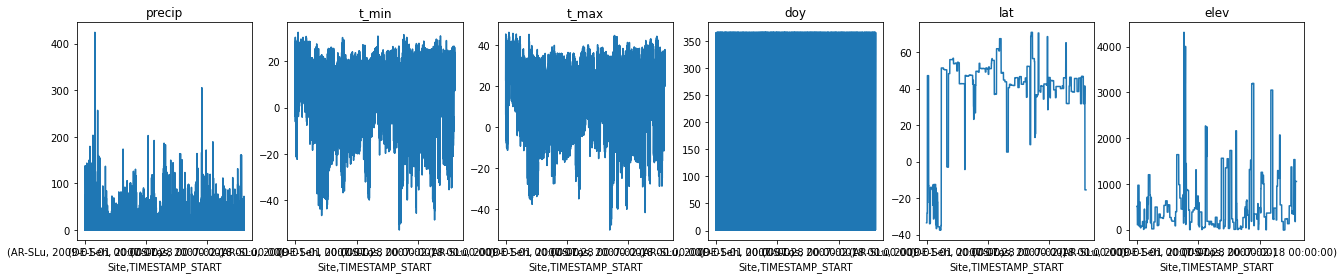

SW_IN_F
LW_IN_F
PA_F
RH


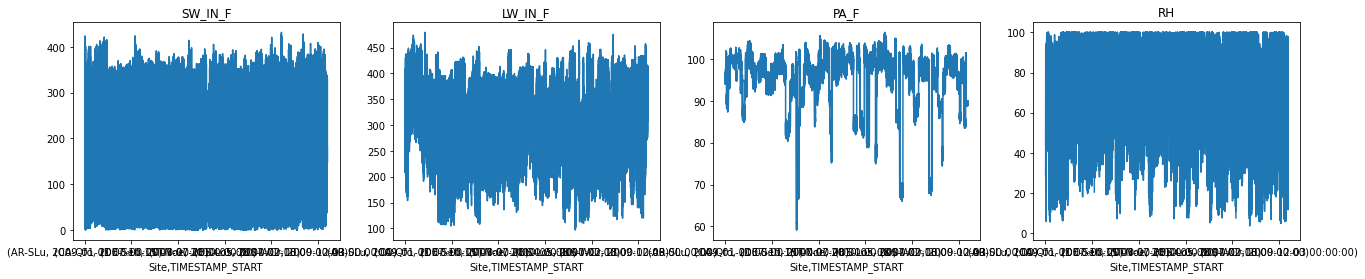

In [55]:
train_vars = ["precip", "t_min", "t_max", "doy", "lat", "elev"]
target_vars = ["SW_IN_F", "LW_IN_F", "PA_F", "RH"]

site = all
plot_vars(df.loc[train_vars])
plot_vars(df[target_vars])

In [ ]:
td = transform_df(trans, d)
plot_vars(td[train_vars])
plot_vars(td[target_vars])

In [ ]:
lookback = 90
train_vars = ["P", "t_min", "t_max", "t", "lat", "elev"]
target_vars = ["SW_IN_F", "LW_IN_F", "PA_F", "RH"]

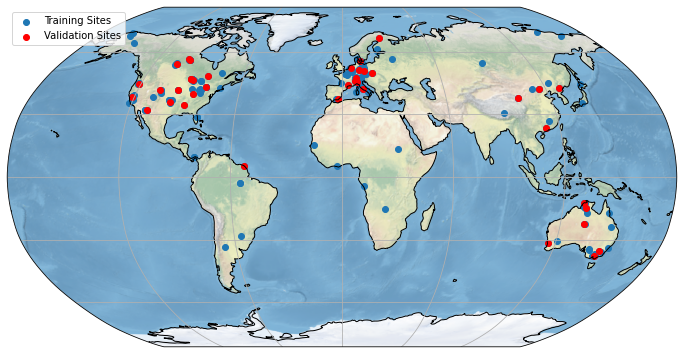

In [26]:
all_sites = all_site_meta.index.get_level_values(0).unique()
meta = get_meta(all_site_meta)
meta = pd.DataFrame.from_dict(meta, orient="index")
# filtering the missing stations 
meta = meta.reindex(df.index.levels[0])

# TODO: stratified sampling instead of hard coding every 5th, or somehow do randomization of the model 
test_meta = meta.sort_values(["lat"])[::5]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.scatter(meta.lon, meta.lat, transform=ccrs.PlateCarree(), label="Training Sites")
ax.scatter(
    test_meta.lon,
    test_meta.lat,
    c="r",
    transform=ccrs.PlateCarree(),
    label="Validation Sites",
)
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
ax.legend()

In [28]:
def split_by_meta(df, keys, test_keys):
    train = []
    val = []

    for key in keys:
        if key in test_keys:
            val.append(df.loc[key])
        else:
            train.append(df.loc[key])
    return train, val

# split the data into train/val groups
# x_train, x_val, y_train, y_val = split(x_data_computed, y_data_computed)
train, val = split_by_meta(df, meta.index.to_list(), test_meta.index.to_list())

# fit the transformers
trans = fit_transformers(train)

In [ ]:
def qc(da):
    if da.isnull().sum() > 0:
        print("nans found")


# create the 3D tensor for the LSTM including a lookback dimension
for name, df_list in zip(["train", "val"], [train, val]):
    da = xr.concat(
        [make_lookback(transform_df(trans, d), lookback=lookback) for d in df_list],
        dim="samples",
    )
    da.name = name
    print(name, da.shape)
    # display(da)
    qc(da)

    # save x data
    mapper = fsspec.get_mapper(f'{SCRATCH}/metml/etl/x_{name}.zarr')
    da.to_dataset(name='x').sel(features=train_vars).chunk({'samples': 10000}).to_zarr(mapper, mode='w', consolidated=True)

    # save y data
    mapper = fsspec.get_mapper(f'{SCRATCH}/metml/etl/y_{name}.zarr')
    da.to_dataset(name='y').sel(features=target_vars).isel(lookback=-1).chunk({'samples': 10000}).to_zarr(mapper, mode='w', consolidated=True)
    

In [ ]:
# TODO: use ONNX for this
with fsspec.open(f'{SCRATCH}/metml/etl/fluxnet_all_transformers.joblib', mode='wb') as f:
    dump(trans, f)  # save for later

In [ ]:
with fsspec.open(f'{SCRATCH}/metml/etl/fluxnet.csv', mode='w') as f:
    df.to_csv(f)
df.head()

In [ ]:
with fsspec.open(f'{SCRATCH}/metml/etl/meta.csv', mode='w') as f:
    meta.to_csv(f)
meta.head()

In [ ]:
with fsspec.open(f'{SCRATCH}/metml/etl/test_meta.csv', mode='w') as f:
    test_meta.to_csv(f)
test_meta.head()

In [ ]:
trans